# Jupyter Notebook for "Quantum Data Encoding Patterns and their Consequences"

### Structure:
1. Prerequisites
    1. Sudoku graph creation and variable definitions
    2. Function definition for the circuit mapping
2. Encodings
    1. One-Hot
    2. Standard Unary
    3. Hypergraph Unary
    4. Binary restrictions
        1. Inequality
        2. Boolean
    5. Binary boolean
    6. Binary inequality

# 1. Prerequisites

## 1.1 Sudoku graph creation and variable definitions

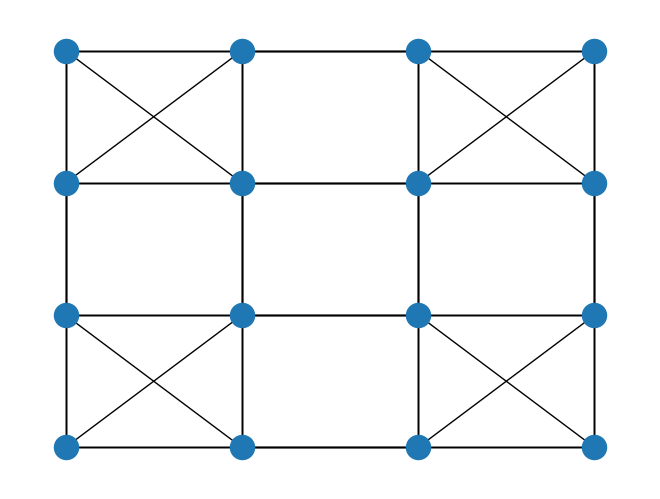

In [1]:
# Standard Python libraries
import numpy as np
import networkx as nx
import math
import sympy as sp
from sympy.abc import i
from sympy.abc import j

# myQLM framework libraries
from qat.opt import GraphColouring, CombinatorialProblem
from qat.opt.boolexpr import Clause
from qat.core import Observable, Term
from qat.vsolve.ansatz import AnsatzFactory


# Create the Sudoku graph
n=2
N = n*n
nb_vertices = N*N
nb_edges = 0.5 * N*N * (3*N - 2*n -1)
G = nx.sudoku_graph(n)

# Define number of bits variables
nb_bits_per_vertex = {'one-hot': N, 'unary': N-1, 'binary': math.ceil(math.log2(N))}
nb_bits = {
    'one-hot': nb_bits_per_vertex['one-hot']*nb_vertices, 
    'unary':   nb_bits_per_vertex['one-hot']*nb_vertices, 
    'binary':  nb_bits_per_vertex['one-hot']*nb_vertices
}

# Define the Ansatz generating strategy
# 'default' 'coloring' 'gray_synth'
circuit_generator_strategy = 'coloring'

# Draw the graph
pos = dict(zip(list(G.nodes()), nx.grid_2d_graph(N, N)))
nx.draw(G, pos=pos)

## 1.2 Function definition for the circuit mapping

In [13]:
# Retrive the list of hyperedges
def get_hyper_edges() -> list[list[int]]:
    edges = []
    # rows
    for row in range(N):
        edge = []
        for cell in range(N):
            edge.append(row*N+cell)
        edges.append(edge)
        
    # columns
    for col in range(N):
        edge = []
        for cell in range(N):
            edge.append(col+N*cell)
        edges.append(edge)
    
    # subgrids
    for grid_i in range(n):
        for grid_j in range(n):
            edge = []
            for i1 in range(grid_i * n, grid_i * n + n):
                for j1 in range(grid_j * n, grid_j * n + n):
                    edge.append(i1*N+j1)
            edges.append(edge)
    return edges

# Calculates the depth of a circuit
def depth(circuit) -> int:
    slices = [set()]
    for op in circuit:
        qbits = op.qbits
        insert_in = None
        for index, slic in enumerate(reversed(slices)):
            if all(qb not in slic for qb in qbits):
                continue
            insert_in = index
            break
        if insert_in is None:
            for qb in qbits:
                slices[0].add(qb)
        elif insert_in == 0:
            slices.append(set(qbits))
        else:
            for qb in qbits:
                slices[len(slices) - insert_in].add(qb)
    return len(slices)

# Breaks down the powers of an Ising-Model
# 1 = x^2 = x^4 = x^6 ..., x = x^3 = x^5 = x^7 ...
def replace_powers(expr):
    return expr.replace(
        lambda x: x.is_Pow and x.exp % 2 == 0, 
        lambda x: 1
    ).replace(
        lambda x: x.is_Pow and x.exp % 2 == 1, 
        lambda x: x.base.func(*x.base.args)
    )

# Transforms a Sympy expression into an observable object that can be passed to the AnsatzFactory
def build_terms(expression, D, nb_slacks_per_edge=0, nb_slacks_per_vertex=0):
    # Define observable size
    observable = Observable(int(D * nb_vertices + nb_slacks_per_edge * nb_edges + nb_slacks_per_vertex * nb_vertices))
    
    # iterate through each term of the expression
    for exp in expression:
        # Filter out numerical values
        if isinstance(exp, sp.Rational) or isinstance(exp, sp.Integer):
            observable.add_term(Term(float(exp), 'I', [0]))
            continue
        # Get the coefficient of a term. If not exists => coefficient = 1
        try:
            coeff = float(exp.args[0])
        except:
            coeff = 1

        # The amount of variable literals in a term
        exp_length = len(exp.atoms(sp.Indexed))
        
        qubits = []
        
        # Iterate through the set of literals in the Term and create a list of indices for corresponding qubit arities
        for arg in exp.atoms(sp.Indexed):
            ind = arg.indices
            if arg.base == sp.IndexedBase('x'):
                qubits.append(ind[0] + ind[1] * nb_vertices)
            else:
                qubits.append(D * nb_vertices + ind[0] * nb_slacks_per_edge + ind[1])
                
        # Create the Ising term
        term = Term(coeff, 'Z'*exp_length, qubits)
        observable.add_term(term)
    return observable

# Prints the depth and the amount of CNOTs of an observable
def print_metrics(encoding: str, observable: Observable, strategy: str, p=1):
    ansatz = AnsatzFactory.qaoa_circuit(observable, p, strategy=strategy)
    print(f'Encoding: {encoding}\n\tDepth: {depth(ansatz)}\n\t#CNOT: {ansatz.count("CNOT")}')

# 2. Encodings

## 2.1 One-Hot

In [4]:
# Amount of decision bits per vertex
D = nb_bits_per_vertex['one-hot']

# Implements the encoding as a Sympy expression
def standard_one_hot_expression(D):
    x = sp.IndexedBase('x')
    expr = 0
    for edge in G.edges:
        expr += sp.summation((x[edge[0], i]+1)/2 * (x[edge[1], i]+1)/2, (i, 0, D-1))
    for vertex in range(nb_vertices):
        expr += (1 - sp.summation((x[vertex, i]+1)/2, (i, 0, D-1)))**2
    expr = sp.expand(expr)
    expr = replace_powers(expr)
    return expr.args

expr = standard_one_hot_expression(D)
observable = build_terms(expr, D)

print_metrics('Standard One-Hot', observable, circuit_generator_strategy)

Encoding: Standard One-Hot
	Depth: 33
	#CNOT: 640


## 2.2 Standard Unary

In [30]:
# Amount of decision bits per vertex
D = nb_bits_per_vertex['unary']

# Additional slack variables:
nb_slacks_per_edge_unary = int(1 + math.floor(math.log2(pow(D, 2) - 1)))

# Implements the encoding as a Sympy expression
def standard_unary_expression(D):
    x = sp.IndexedBase('x')
    s = sp.IndexedBase('s')
    expr = 0
    for edge_number, edge in enumerate(G.edges):
        slacks = sp.summation(2**i * (s[edge_number, i]+1)/2, (i, 0, nb_slacks_per_edge_unary - 1))
        expr += (-(sp.summation((x[edge[0], i]+1)/2 - (x[edge[1], i]+1)/2, (i, 0, D-1)))**2 + 1 + slacks)**2
    expr = sp.expand(expr)
    expr = replace_powers(expr)
    return expr.args
        
        
expr = standard_unary_expression(D)
observable = build_terms(expr, D, nb_slacks_per_edge=nb_slacks_per_edge_unary)

print_metrics('Standard Unary', observable, circuit_generator_strategy)

Encoding: Standard Unary
	Depth: 1495
	#CNOT: 20256


## 2.3 Hypergraph Unary

In [5]:
# Amount of decision bits per vertex
D = nb_bits_per_vertex['unary']

# Implements the encoding as a Sympy expression
def hypergraph_unary_expression(D):
    x = sp.IndexedBase('x')
    expr = 0
    for iteration in range(D):
        for edge in get_hyper_edges():
            expr += (sum([(x[edge[k], iteration]+1)/2 for k in range(len(edge))]) - iteration - 1)**2
    
    for vertex in range(nb_vertices):
        expr += sp.summation((x[vertex, i]+1)/2 - (x[vertex, i]+1)/2 * (x[vertex, i+1]+1)/2, (i, 0, D-2))
    expr = sp.expand(expr)
    expr = replace_powers(expr)
    return expr.args

expr = hypergraph_unary_expression(D)
observable = build_terms(expr, D)
print_metrics('Hypergraph Unary', observable, circuit_generator_strategy)

Encoding: Hypergraph Unary
	Depth: 29
	#CNOT: 400


## 2.4 Binary restrictions
Only necessary, if $N^2 \neq 2^k$ for any $k\in \mathbb{N}$

2.4.1 and 2.4.2 show the encodings for $n=3$ independently from the other encodings

### 2.4.1 Inequality

In [12]:
N_restr = 9
nb_vertices_restr = N_restr**2
D = math.ceil(math.log2(N_restr))

nb_bits = nb_vertices_restr * D

nb_slacks_per_vertex = int(1 + math.floor(math.log2(N-1)))
nb_slacks = int(nb_vertices_restr * nb_slacks_per_vertex)

def binary_value_restriction_inequality(D):
    n = sp.symbols('i')
    x_n = sp.Function('x')(n)
    s_n = sp.Function('s')(n)
    
    expression = (sp.summation(2**i * (x_n+1)/2, (i, 0, D-1)) - N_restr + 1
                  + sp.summation(2**i * (s_n+1)/2, (i, 0, math.floor(math.log2(D - 1)))))**2
    expanded = replace_powers(sp.expand(expression))
    return(expanded.args)
                             
exp_terms = binary_value_restriction_inequality(D)

def build_terms_binary_inequality_restriction(expression):
    observable = Observable(nb_bits + nb_slacks)
    variable_matching = {'x': 0, 's': 1}
    for vertex in range(nb_vertices_restr):
        variables = [[vertex + arity*nb_vertices_restr for arity in range(D)],  
                     [nb_bits + s + vertex*nb_slacks_per_vertex for s in range(nb_slacks_per_vertex)]]
        for exp in expression:
            if isinstance(exp, sp.Rational) or isinstance(exp, sp.Integer):
                observable.add_term(Term(int(exp), 'I', [0]))
                continue
                
            try:
                coeff = float(exp.args[0])
            except:
                coeff = 1

            exp_length = len(exp.atoms(sp.Function))
            qubits = []
            for arg in exp.atoms(sp.Function):
                var_type = variable_matching[str(arg.name)]
                var_arity = arg.args[0]
                assigned_var = variables[var_type][var_arity]
                qubits.append(assigned_var)
            term = Term(coeff, 'Z'*exp_length, qubits)
            observable.add_term(term)
    return observable

observable = build_terms_binary_inequality_restriction(exp_terms)
print_metrics('Binary Inequality Restriction', observable, circuit_generator_strategy)

Encoding: Binary Inequality Restriction
	Depth: 23
	#CNOT: 2430


### 2.4.2 Boolean SAT

In [9]:
N_restr = 9
nb_vertices_restr = N_restr**2
max_I = N_restr -1
binary_I = bin(max_I)[2:]

# Define bits, s.t. the binary bitstring is given by: 'x = xi mod N^2'
bit_labels = [[vertice + bit_position*nb_vertices_restr for bit_position in range(math.ceil(math.log2(N_restr)))] for vertice in range(nb_vertices_restr)]
def rec_expression_builder(bitstring, expression=''):
    if len(bitstring) == 0 or '0' not in bitstring:
        return expression

    current_bit = bitstring[0]
    if current_bit == '1':
        expression = rec_expression_builder(bitstring[1:], f'{expression}(x({len(bitstring)-1})+1)/2 *')
    if current_bit == '0':
        expression = rec_expression_builder(bitstring[1:], f'{expression}((x({len(bitstring)-1})+1)/2+')
        expression = f'{expression})'
    return expression

formatted_string = rec_expression_builder(binary_I).replace('*)', ')').replace('+)', ')')
sp_exp = sp.expand(sp.sympify(formatted_string))

def build_terms_binary_boolean_restriction(expression, l):
    observable = Observable(l * nb_vertices_restr)
    for vertex in range(nb_vertices_restr):
        for exp in expression:
            if isinstance(exp, sp.Rational) or isinstance(exp, sp.Integer):
                observable.add_term(Term(int(exp), 'I', [0]))
                continue
            try:
                coeff = float(exp.args[0])
            except:
                coeff = 1

            exp_length = len(exp.atoms(sp.Function))
            qubits = []
            for arg in exp.atoms(sp.Function):
                var_arity = arg.args[0]
                assigned_var = bit_labels[vertex][var_arity]
                qubits.append(assigned_var)
            term = Term(coeff, 'Z'*exp_length, qubits)
            observable.add_term(term)
    return observable

length = len(sp_exp.atoms(sp.Function))
observable = build_terms_binary_boolean_restriction(sp_exp.args, length)
print_metrics('Binary SAT Restriction', observable, circuit_generator_strategy)

Encoding: Binary SAT Restriction
	Depth: 12
	#CNOT: 486


## 2.5 Binary boolean
This encodings does not incorporate the value restrictions from 2.4

In [14]:
# Amount of decision bits per vertex
D = nb_bits_per_vertex['binary']

# Implements the encoding as a Sympy expression
def binary_boolean_expression(D):
    x = sp.IndexedBase('x')
    expr = 0
    for edge in G.edges:
        expr += sp.product(2*(x[edge[0], i]+1)/2 * (x[edge[1], i]+1)/2 - (x[edge[0], i]+1)/2 - (x[edge[1], i]+1)/2, (i, 0, D-1))
    
    expr = sp.expand(expr)
    expr = replace_powers(expr)
    return expr.args

expr = binary_boolean_expression(D)
observable = build_terms(expr, D)
print_metrics('Binary Boolean', observable, circuit_generator_strategy)

Encoding: Binary Boolean
	Depth: 72
	#CNOT: 560


## 2.6 Binary inequality
This encodings does not incorporate the value restrictions from 2.4

In [15]:
# Amount of decision bits per vertex
D = nb_bits_per_vertex['binary']

# Number of slacks
nb_slacks_per_edge_binary = int(1 + math.floor(math.log2(D - 1)))

# Implements the encoding as a Sympy expression
def binary_inequality_expression(D):
    x = sp.IndexedBase('x')
    s = sp.IndexedBase('s')
    expr = 0
    for edge_number, edge in enumerate(G.edges):
        slacks = sp.summation(2**i * (s[edge_number, i]+1)/2, (i, 0, nb_slacks_per_edge_binary - 1))
        expr += (sp.summation(2*(x[edge[0], i]+1)/2 * (x[edge[1], i]+1)/2 - (x[edge[0], i]+1)/2 - (x[edge[1], i]+1)/2, (i, 0, D-1)) + 1 + slacks)**2
    
    expr = sp.expand(expr)
    expr = replace_powers(expr)
    return expr.args

expr = binary_inequality_expression(D)
observable = build_terms(expr, D, nb_slacks_per_edge=nb_slacks_per_edge_binary)
print_metrics('Binary inequality', observable, circuit_generator_strategy)

Encoding: Binary inequality
	Depth: 109
	#CNOT: 1008
